## Custom SVM class

In [1]:
import pandas as pd
import numpy as np

class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, num_classes=None):
        """
        Initialize the Logistic Regression model
        
        Parameters:
        - learning_rate: step size for gradient descent
        - num_iterations: number of training iterations
        - num_classes: number of unique classes in the dataset
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.num_classes = num_classes
        self.weights = None
        self.bias = None
        self.class_mapping = None  # To handle zero-based indexing

    def _softmax(self, z):
        """
        Softmax activation function for multiclass classification
        Prevents numerical instability by subtracting max value
        
        Parameters:
        - z: input array of logits
        
        Returns:
        - Softmax probabilities
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot_encode(self, y):
        """
        Convert labels to one-hot encoded format
        
        Parameters:
        - y: original labels
        
        Returns:
        - One-hot encoded labels
        """
        # Remap labels to zero-based index if needed
        if self.class_mapping is None:
            unique_classes = np.unique(y)
            self.class_mapping = {orig: idx for idx, orig in enumerate(unique_classes)}
            self.reverse_mapping = {idx: orig for orig, idx in self.class_mapping.items()}
        
        # Map original labels to zero-based index
        y_mapped = np.array([self.class_mapping[label] for label in y])
        
        # Create one-hot encoding
        one_hot = np.zeros((y.shape[0], self.num_classes))
        one_hot[np.arange(y.shape[0]), y_mapped] = 1
        return one_hot

    def fit(self, X, y):
        """
        Train the logistic regression model
        
        Parameters:
        - X: input features (num_samples, num_features)
        - y: target labels
        """
        # Determine number of classes if not specified
        unique_classes = np.unique(y)
        self.num_classes = len(unique_classes)
        
        # Initialize weights and bias
        num_features = X.shape[1]
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros((1, self.num_classes))
        
        # One-hot encode labels
        Y_one_hot = self._one_hot_encode(y)
        
        # Gradient descent
        for _ in range(self.num_iterations):
            # Forward pass
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._softmax(linear_model)
            
            # Compute gradients
            dw = (1/X.shape[0]) * np.dot(X.T, (y_predicted - Y_one_hot))
            db = (1/X.shape[0]) * np.sum(y_predicted - Y_one_hot, axis=0, keepdims=True)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """
        Make predictions on input data
        
        Parameters:
        - X: input features
        
        Returns:
        - Predicted class labels (original class labels)
        """
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._softmax(linear_model)
        
        # Get indices of max probabilities
        predicted_indices = np.argmax(y_predicted, axis=1)
        
        # Map back to original class labels
        return np.array([self.reverse_mapping[idx] for idx in predicted_indices])

    def predict_proba(self, X):
        """
        Predict class probabilities
        
        Parameters:
        - X: input features
        
        Returns:
        - Predicted class probabilities
        """
        linear_model = np.dot(X, self.weights) + self.bias
        return self._softmax(linear_model)

    def accuracy(self, X, y):
        """
        Compute model accuracy
        
        Parameters:
        - X: input features
        - y: true labels
        
        Returns:
        - Accuracy score
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)

def preprocess_sign_mnist(train_data, test_data):
    """
    Preprocess Sign MNIST dataset
    
    Parameters:
    - train_data: Training dataframe
    - test_data: Testing dataframe
    
    Returns:
    - Preprocessed X_train, X_test, y_train, y_test
    """
    # Separate features and labels
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values
    
    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    print("Unique training classes:", np.unique(y_train))
    print("Unique testing classes:", np.unique(y_test))
    
    return X_train, X_test, y_train, y_test

def train_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Train custom Logistic Regression on Sign MNIST
    
    Parameters:
    - X_train: Training features
    - X_test: Testing features
    - y_train: Training labels
    - y_test: Testing labels
    
    Returns:
    - Trained model
    - Training and test accuracies
    """
    # Create and train the model
    clf = CustomLogisticRegression(
        learning_rate=0.1,  # You can tune this
        num_iterations=1000,  # You can increase for better convergence
        num_classes=len(np.unique(y_train))
    )
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Compute accuracies
    train_accuracy = clf.accuracy(X_train, y_train)
    test_accuracy = clf.accuracy(X_test, y_test)
    
    return clf, train_accuracy, test_accuracy

# Main execution
def main():
    # Load the training dataset
    train_csv_path = './archive/sign_mnist_train.csv'
    train_data = pd.read_csv(train_csv_path)
    
    # Load the testing dataset
    test_csv_path = './archive/sign_mnist_test.csv'
    test_data = pd.read_csv(test_csv_path)
    
    # Preprocess the data
    X_train, X_test, y_train, y_test = preprocess_sign_mnist(train_data, test_data)
    
    # Train the model
    model, train_acc, test_acc = train_logistic_regression(X_train, X_test, y_train, y_test)
    
    # Print results
    print(f"Training Accuracy: {train_acc * 100:.2f}%")
    print(f"Testing Accuracy: {test_acc * 100:.2f}%")
    
    return model, X_test, y_test

# Optional: Confusion Matrix and Classification Report
def evaluate_model(model, X_test, y_test):
    """
    Generate detailed model evaluation
    
    Parameters:
    - model: Trained logistic regression model
    - X_test: Test features
    - y_test: Test labels
    """
    # Predictions
    y_pred = model.predict(X_test)
    

# Run the main function
if __name__ == "__main__":
    model, X_test, y_test = main()
    evaluate_model(model, X_test, y_test)

Unique training classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Unique testing classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Training Accuracy: 76.39%
Testing Accuracy: 63.43%
Confusion Matrix:
[[323   0   0   0   0   0   0   0   0   0   0   0   3   4   0   0   0   1
    0   0   0   0   0   0]
 [  0 349   0   0   0   0   0   0   0  75   0   0   0   0   0   0   0   0
    0   0   0   8   0   0]
 [  0   0 264   0   0  16   0   0   0   0   5   0   0  19   0   0   0   0
    0   0   0   0   6   0]
 [  0   0   0 153   0   0   0   0   0  15   0   0  14   0   0   0   0   5
    0   0   6   0  52   0]
 [  0   0   0   0 435   0   0   0   0   0   0   0   0   0   0   0   0  63
    0   0   0   0   0   0]
 [  0   0  20   0   0 201   0   0   0   0   1   0   0   5   0   0   0   0
    0   0   0  20   0   0]
 [  0   0   0  20   0   0 203  18   0   0   0   0  21  14   0  19   0   0
   52   0   0   0   1   0]
 [  0   0   0   0  16   0  

In [3]:
train_csv_path = './archive/sign_mnist_train.csv'
train_data = pd.read_csv(train_csv_path)
    
    # Load the testing dataset
test_csv_path = './archive/sign_mnist_test.csv'
test_data = pd.read_csv(test_csv_path)


In [4]:
 # Preprocess the data
X_train, X_test, y_train, y_test = preprocess_sign_mnist(train_data, test_data)
    
    # Train the model
model, train_acc, test_acc = train_logistic_regression(X_train, X_test, y_train, y_test)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

Unique training classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Unique testing classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Training Accuracy: 76.39%
Testing Accuracy: 63.43%


In [5]:
y_pred = model.predict(X_test)

In [7]:
def custom_confusion_matrix(y_true, y_pred, num_classes, class_names=None):
    """
    Compute the confusion matrix manually and plot it with a stylish design.

    Parameters:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        num_classes: Number of unique classes
        class_names: List of class names corresponding to the classes (optional)

    Returns:
        Confusion matrix as a 2D numpy array
    """

    # Initialize confusion matrix
    matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        matrix[true][pred] += 1  # Increment the cell corresponding to (true, predicted)

    # Plotting the styled confusion matrix
    plt.figure(figsize=(12,10))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes),
                linewidths=0.5, linecolor='black')

    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

    return matrix


def custom_classification_report(y_true, y_pred, num_classes, class_names=None):
    """
    Compute and display the classification report in a styled table format.

    Parameters:
        y_true: Array of true labels
        y_pred: Array of predicted labels
        num_classes: Number of unique classes
        class_names: List of class names (optional)

    Returns:
        A pandas DataFrame containing precision, recall, F1-score, and support.
    """
    import pandas as pd
    import numpy as np

    # Compute confusion matrix
    cm = custom_confusion_matrix(y_true, y_pred, num_classes)

    # Initialize report dictionary
    report = {}
    for cls in range(num_classes):
        true_positive = cm[cls, cls]
        false_positive = sum(cm[:, cls]) - true_positive
        false_negative = sum(cm[cls, :]) - true_positive

        # Handle cases with no positive or negative samples for this class
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        support = sum(y_true == cls)

        report[cls] = {
            "precision": precision,
            "recall": recall,
            "f1-score": f1_score,
            "support": support
        }

    # Convert the report dictionary to a DataFrame
    class_names = class_names if class_names else [f"Class {i}" for i in range(num_classes)]
    df_report = pd.DataFrame.from_dict(report, orient='index')
    df_report.index = class_names

    # Add average metrics
    macro_avg = df_report[["precision", "recall", "f1-score"]].mean()
    weighted_avg = df_report[["precision", "recall", "f1-score"]].multiply(df_report["support"], axis=0).sum() / df_report["support"].sum()

    df_report.loc["macro avg"] = macro_avg
    df_report.loc["weighted avg"] = weighted_avg

    print("Accuracy: ", sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred)) / len(y_true))

    return df_report

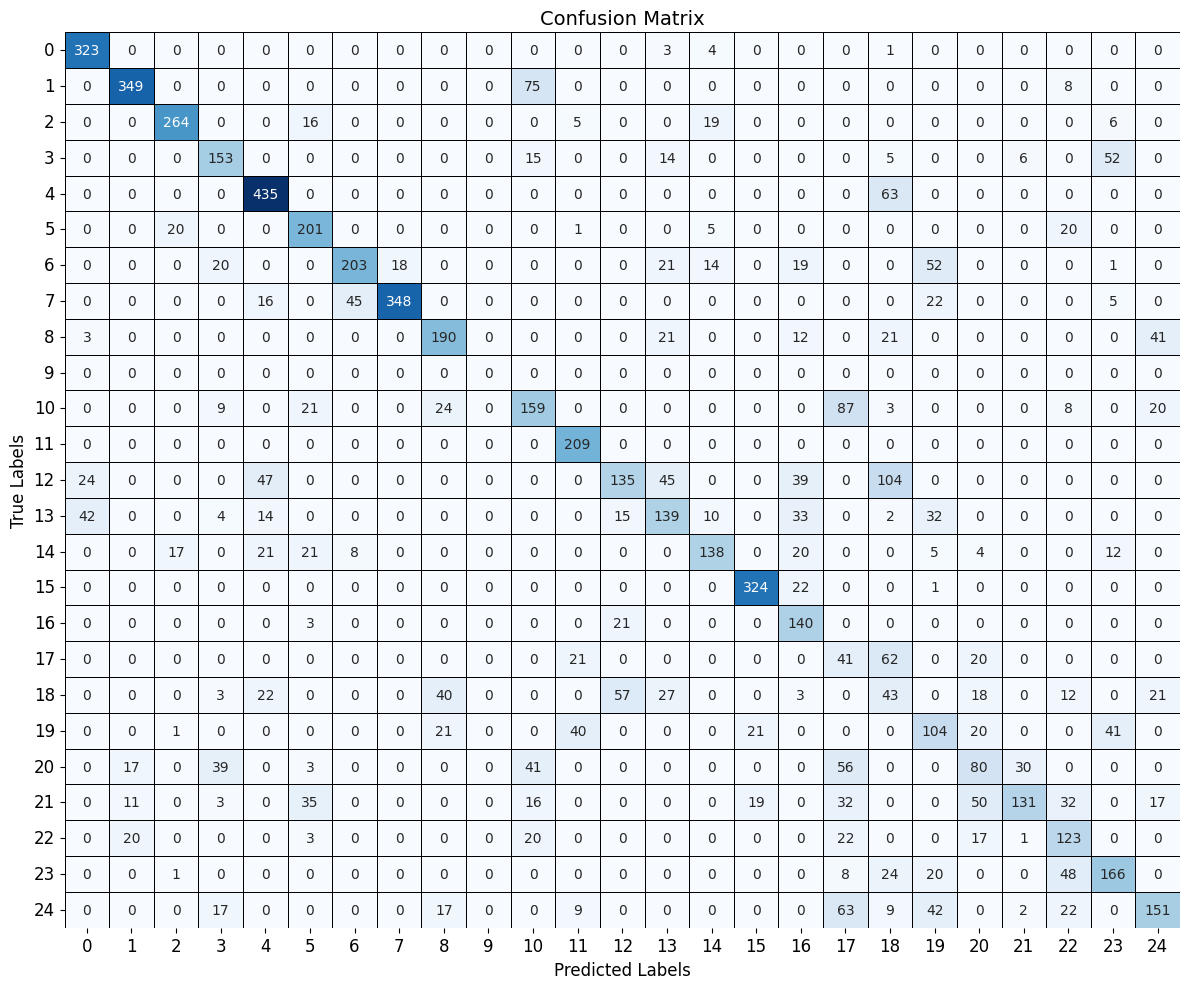

Accuracy:  0.6342721695482432


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# cm = custom_classification_report(y_test, y_pred)

# Number of unique classes
num_classes = len(np.unique(y_test)) + 1

# Optional: Define class names (e.g., 0-23 for Sign Language MNIST)
class_names = [str(i) for i in range(num_classes)]

svm_report = custom_classification_report(y_test, y_pred,num_classes=num_classes, class_names=class_names)